# Lab - YOLOv4-Tiny - Pretrained YOLOv4-Tiny Webcam Inference
## E6692 Spring 2022

In this part we do inference with YOLOv4-Tiny through the webcam. You will load the pretrained YOLOv4-Tiny [Darknet](https://pjreddie.com/darknet/) weights into a PyTorch implementation of the model. The weights we are using were trained on the **COCO (Common Objects in COntext)** computer vision dataset comprised of 80 classes of common objects. Read more about the dataset [here](https://cocodataset.org/#home). Complete this notebook on the Jetson Nano.

In [1]:
# import standard libraries
import torch
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# import custom libraries
from darknet_utils.darknet_to_pytorch import load_darknet_as_pytorch
from darknet_utils.utils import plot_boxes_cv2, post_processing, nms_cpu
from darknet_utils.torch_utils import detect
from darknet_utils.inference import image_inference, webcam_inference, get_class_names
from darknet_utils.download_images import download_n_images

# define weights and configuration file paths
cfg_path = './cfg/yolov4-COCO-pretrained.cfg'
weights_path = './weights/yolov4-tiny.weights'

device = 'cuda'

%load_ext autoreload
%autoreload 2

%matplotlib inline

tqdm installed.
  Cloning https://github.com/Joeclinton1/google-images-download.git to /tmp/pip-req-build-h2wx7xyz


  Running command git clone --filter=blob:none --quiet https://github.com/Joeclinton1/google-images-download.git /tmp/pip-req-build-h2wx7xyz


  Resolved https://github.com/Joeclinton1/google-images-download.git to commit ce512d99ff4c5f74a3cfa3bcf83c6a5b05bd873f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 968.8/968.8 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.0/359.0 KB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 KB 13.7 MB/s eta 0:00:00
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=15632 sha256=48a5d58f457135e061d498877e8d45488851c42ab0850381bed1e52734fb1eb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-y4w1x03e/wheels/79/5c/d2/2569a4f55ff29b3c4d6b1114d5110a70a79afbf381e6eb3e87
Successfully built google-images-download
git+https://github.com/Joeclinton1/google-images-download.git installed.


The PyTorch YOLOv4-Tiny model is defined in **darknet_utils/darknet_model.py**. Note that the model contains a "load_weights" function. The model is also defined by parsing the configuration file. This allows for easy reconfiguration and versioning of the model. Load the pretrained YOLOv4-Tiny weights into the PyTorch implementation with the function **load_darknet_as_pytorch()**.

In [34]:
# TODO: use load_darknet_as_pytorch() to load the pretrained YOLOv4-Tiny PyTorch model
model = load_darknet_as_pytorch(cfg_path, weights_path)

Next you will download images for sample inference. We will use **download_n_images()** as we did in previous labs. Note that the model was trained on 80 classes of objects. You may want to adjust your query to reflect these classes. See **ms_coco_classnames.txt** for the full list of classes. 

In [31]:
# TODO: Download at least 3 images with download_n_images() to use for inference.

query = 'dog'
n = 3

download_n_images(query, n)


Item no.: 1 --> Item name = dog
Evaluating...
Starting Download...
Image URL: https://www.aaha.org/contentassets/e3033f0ae87246cbb1ef8136c13d508f/imagehywzk.png
Completed Image ====> 1.imagehywzk.png
Image URL: https://www.aspca.org/sites/default/files/dog-care_dog-bite-prevention_main-image.jpg
Completed Image ====> 2.dog-care_dog-bite-prevention_main-image.jpg
Image URL: https://www.nylabone.com/-/media/Images/Nylabone-NA/US/Dog101/dog-breeds-a-z/cropped-dog-breeds-white-background.jpg
Completed Image ====> 3.cropped-dog-breeds-white-background.jpg

Errors: 0



In **darknet_utils.inference**, implement the function **get_class_names()**. 

In [30]:
# TODO: use get_class_names() to load the COCO classes as a dictionary of class indices and class names.

class_names = {}

classnames_path = 'ms_coco_classnames.txt'
class_names = get_class_names(classnames_path)

print(class_names)

{'0': '__background__', '1': 'person', '2': 'bicycle', '3': 'car', '4': 'motorcycle', '5': 'airplane', '6': 'bus', '7': 'train', '8': 'truck', '9': 'boat', '10': 'traffic light', '11': 'fire hydrant', '12': 'stop sign', '13': 'parking meter', '14': 'bench', '15': 'bird', '16': 'cat', '17': 'dog', '18': 'horse', '19': 'sheep', '20': 'cow', '21': 'elephant', '22': 'bear', '23': 'zebra', '24': 'giraffe', '25': 'backpack', '26': 'umbrella', '27': 'handbag', '28': 'tie', '29': 'suitcase', '30': 'frisbee', '31': 'skis', '32': 'snowboard', '33': 'sports ball', '34': 'kite', '35': 'baseball bat', '36': 'baseball glove', '37': 'skateboard', '38': 'surfboard', '39': 'tennis racket', '40': 'bottle', '41': 'wine glass', '42': 'cup', '43': 'fork', '44': 'knife', '45': 'spoon', '46': 'bowl', '47': 'banana', '48': 'apple', '49': 'sandwich', '50': 'orange', '51': 'broccoli', '52': 'carrot', '53': 'hot dog', '54': 'pizza', '55': 'donut', '56': 'cake', '57': 'chair', '58': 'couch', '59': 'potted plant',

In **darknet_utils.inference** complete the function **image_inference()**. Then use it to perform inference with the pretrained YOLOv4-Tiny on at least 3 of the images you downloaded. You will need to define a confidence threshold and an [NMS threshold](https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/#:~:text=Deep%20Learning%20Face%20Detection%20Object,out%20of%20many%20overlapping%20entities.) for the model.

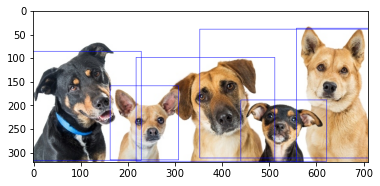

In [81]:
# TODO: complete image_inference() and use it to perform inference on the images you downloaded.
img_path = './downloads/dog/3.cropped-dog-breeds-white-background.jpg'
conf_thresh = 0.1
nms_thresh = 0.2

image_inference(img_path, model, conf_thresh, nms_thresh, class_names)

How do the detections change as you adjust the confidence and NMS thresholds?

**TODO:** Your answer here.

When increase the confidence, then less number of dogs were detected because we only assume those areas with high confidence are true objects. When increase the NMS thresholds, the number of bboxes on the detected area incresed.


Use the function **webcam_inference()** to do pretrained inference through the webcam of the Jetson Nano.

In [ ]:
webcam_inference(pretrained_yolo_tiny, class_names=class_names)

How does the YOLOv4-Tiny inference compare to the live inferences you have performed in previous labs? What happens if you increase the resolution of the live inference? Experiment with detecting and describe edge cases where the detection accuracy is poor.

**TODO:** Your answer here.

**TODO:** Insert a screenshot of your webcam pretrained inference with some good detections of COCO objects. 